# Integrated Modeling of Dubai City

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Convert-map-file-to-GMNS-data-files" data-toc-modified-id="Convert-map-file-to-GMNS-data-files-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convert map file to GMNS data files</a></span><ul class="toc-item"><li><span><a href="#Downoad-sample-data-from-Github" data-toc-modified-id="Downoad-sample-data-from-Github-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Downoad sample data from Github</a></span></li><li><span><a href="#How-to-install-osm2gmns" data-toc-modified-id="How-to-install-osm2gmns-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>How to install osm2gmns</a></span></li><li><span><a href="#How-to-update-osm2gmns" data-toc-modified-id="How-to-update-osm2gmns-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>How to update osm2gmns</a></span></li><li><span><a href="#Please-make-sure-you-have-v0.7.3-instaled." data-toc-modified-id="Please-make-sure-you-have-v0.7.3-instaled.-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Please make sure you have v0.7.3 instaled.</a></span></li><li><span><a href="#Read-network-from-data-we-just-downloaded" data-toc-modified-id="Read-network-from-data-we-just-downloaded-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Read network from data we just downloaded</a></span></li><li><span><a href="#Show-GMNS-files-on-the-map" data-toc-modified-id="Show-GMNS-files-on-the-map-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Show GMNS files on the map</a></span></li></ul></li><li><span><a href="#Generate-zone-grids-and-zonal-geometry-information" data-toc-modified-id="Generate-zone-grids-and-zonal-geometry-information-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate zone grids and zonal geometry information</a></span></li><li><span><a href="#Trip-generation" data-toc-modified-id="Trip-generation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trip generation</a></span></li><li><span><a href="#Trip-distribution-and-create-zonal-demand" data-toc-modified-id="Trip-distribution-and-create-zonal-demand-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Trip distribution and create zonal demand</a></span></li><li><span><a href="#plot4gmns-Tutorial" data-toc-modified-id="plot4gmns-Tutorial-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>plot4gmns Tutorial</a></span><ul class="toc-item"><li><span><a href="#Install-Package" data-toc-modified-id="Install-Package-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Install Package</a></span></li><li><span><a href="#import-the-package" data-toc-modified-id="import-the-package-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>import the package</a></span></li><li><span><a href="#prepare-your-absolute-directory-for-the-input" data-toc-modified-id="prepare-your-absolute-directory-for-the-input-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>prepare your absolute directory for the input</a></span></li></ul></li></ul></div>


## 1. Subarea Cut - Convert map file to GMNS data files 

Convert map file to GMNS data files, the first step of intergated modeling is to covert OpenStreetMap file (map.osm)for any subarea cut we have into GMNS data specification format (.csv)
- Python tool: **OSM2GMNS**
- tool function: *getNetFromFile()*, *outputNetToCSV*
- inputs: 'map.osm'
- outputs: 'node.csv', 'link.csv' , 'poi.csv'(optional)


### 1.1 Downoad sample data from Github
   Create a class to download data from Github directly

In [68]:
# -*- coding:utf-8 -*-
##############################################################
# Created Date: Monday, February 20th 2023
# Contact Info: luoxiangyong01@gmail.com
# Author/Copyright: Mr. Xiangyong Luo
##############################################################

import re
import os
import urllib.request
import json
import sys

# Dont's worry about the class defined here, we use this class directly.

# a class to download fold/file from Github directly.
class GitHubFileDownloader:
    def __init__(self, repo_url, flatten_files=True, output_dir="./"):
        self.repo_url = repo_url
        self.flatten = flatten_files
        self.output_dir = output_dir

    def create_url(self, url):  # sourcery skip: use-getitem-for-re-match-groups
        """
        From the given url, produce a URL that is compatible with Github's REST API. Can handle blob or tree paths.
        """
        repo_only_url = re.compile(r"https:\/\/github\.com\/[a-z\d](?:[a-z\d]|-(?=[a-z\d])){0,38}\/[a-zA-Z0-9]+$")
        re_branch = re.compile("/(tree|blob)/(.+?)/")

        # Check if the given url is a url to a GitHub repo. If it is, tell the
        # user to use 'git clone' to download it
        if re.match(repo_only_url, url):
            print("✘ The given url is a complete repository. Use 'git clone' to download the repository")
            sys.exit()

        # extract the branch name from the given url (e.g master)
        branch = re_branch.search(url)
        download_dirs = url[branch.end():]
        api_url = (url[:branch.start()].replace("github.com", "api.github.com/repos", 1) + "/contents/" + download_dirs + "?ref=" + branch.group(2))
        return api_url, download_dirs

    def download(self):
        """ Downloads the files and directories in repo_url. If flatten is specified, the contents of any and all
        sub-directories will be pulled upwards into the root folder. """

        # generate the url which returns the JSON data
        api_url, download_dirs = self.create_url(self.repo_url)

        # To handle file names.
        if self.flatten:
            dir_out = self.output_dir

        elif len(download_dirs.split(".")) == 0:
            dir_out = os.path.join(slef.output_dir, download_dirs)
        else:
            dir_out = os.path.join(self.output_dir, "/".join(download_dirs.split("/")[:-1]))
        try:
            opener = urllib.request.build_opener()
            opener.addheaders = [('User-agent', 'Mozilla/5.0')]
            urllib.request.install_opener(opener)
            response = urllib.request.urlretrieve(api_url)
        except KeyboardInterrupt:
            # when CTRL+C is pressed during the execution of this script,
            # bring the cursor to the beginning, erase the current line, and dont make a new line
            print("✘ Got interrupted")
            sys.exit()

        if not self.flatten:
            # make a directory with the name which is taken from
            # the actual repo
            os.makedirs(dir_out, exist_ok=True)

        # total files count
        total_files = 0

        with open(response[0], "r") as f:
            data = json.load(f)
            # getting the total number of files so that we
            # can use it for the output information later
            total_files += len(data)

            # If the data is a file, download it as one.
            if isinstance(data, dict) and data["type"] == "file":
                try:
                    # download the file
                    opener = urllib.request.build_opener()
                    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
                    urllib.request.install_opener(opener)
                    urllib.request.urlretrieve(data["download_url"], os.path.join(dir_out, data["name"]))
                    # bring the cursor to the beginning, erase the current line, and dont make a new line
                    print("Downloaded: " + "{}".format(data["name"]))

                    return total_files
                except KeyboardInterrupt:
                    # when CTRL+C is pressed during the execution of this script,
                    # bring the cursor to the beginning, erase the current line, and dont make a new line
                    print("✘ Got interrupted")
                    sys.exit()

            for file in data:
                file_url = file["download_url"]
                file_name = file["name"]
                file_path = file["path"]

                if self.flatten:
                    path = os.path.basename(file_path)
                else:
                    path = file_path
                dirname = os.path.dirname(path)

                if dirname != '':
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                else:
                    pass

                if file_url is not None:
                    try:
                        opener = urllib.request.build_opener()
                        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
                        urllib.request.install_opener(opener)
                        # download the file
                        urllib.request.urlretrieve(file_url, path)

                        # bring the cursor to the beginning, erase the current line, and dont make a new line
                        print(f"Downloaded: {file_name}")

                    except KeyboardInterrupt:
                        # when CTRL+C is pressed during the execution of this script,
                        # bring the cursor to the beginning, erase the current line, and dont make a new line
                        print("✘ Got interrupted")
                        sys.exit()
                else:
                    self.download(file["html_url"], flatten, download_dirs)

        return total_files


In [70]:
# Download Dubai sample data from github
# the url on github is: https://github.com/xyluo25/OSM2GMNS/tree/master/sample%20networks/Dubai 

url = r"https://github.com/MustafaGada7/Integrated-Modeling/blob/main/dubai_area1.osm"
GitHubFileDownloader(url).download()

Downloaded: dubai_area1.osm


12

### 1.2 Install osm2gmns package

In [71]:
pip install osm2gmns

Note: you may need to restart the kernel to use updated packages.


### 1.3 Update osm2gmns Package

In [72]:
pip install osm2gmns --upgrade

Note: you may need to restart the kernel to use updated packages.


### 1.4 Check if the osm2gmns v0.7.3 installed.

In [73]:
import osm2gmns as og

### 1.5 Read network from data we just downloaded

In [74]:
network = og.getNetFromFile('dubai_area1.osm', POI=True)
og.generateNodeActivityInfo(network)
og.consolidateComplexIntersections(network)
# og.outputNetToCSV(network, output_folder='consolidated')
og.outputNetToCSV(network, encoding='utf-8')

arguments used for network parsing:
  filename: dubai_area1.osm
  network_types: ('auto',)
  link_types: all
  POI: True
  POI_sampling_ratio: 1.0
  strict_mode: True
  offset: no
  min_nodes: 1
  combine: False
  bbox: None
  default_lanes: False
  default_speed: False
  default_capacity: False
  start_node_id: 0
  start_link_id: 0

Building Network from OSM file
  reading osm file
  parsing osm network
    generating nodes and links
    generating POIs
  number of nodes: 561, number of links: 824, number of pois: 2472
Generating Node Activity Information
Consolidating Complex Intersections
    0 intersections have been consolidated
Outputting Network Files


### 1.6 Show GMNS files on the map

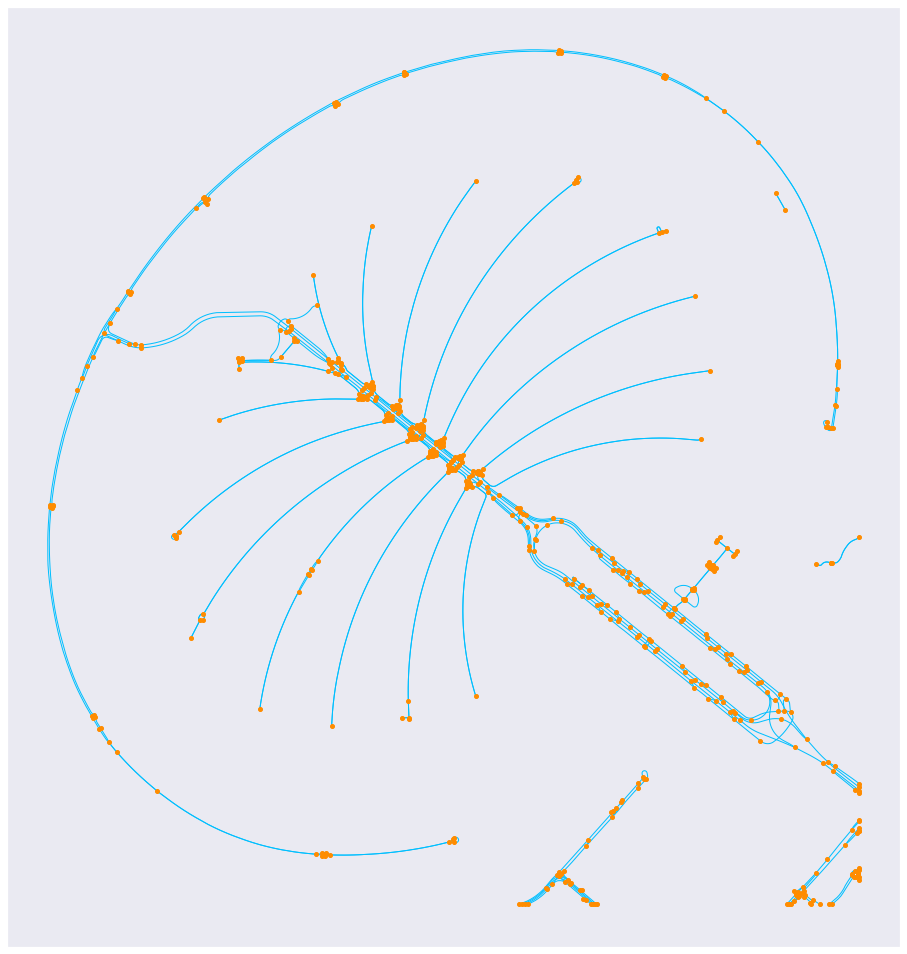

In [75]:
og.show(network)

## 2. Trip Generation
### 2.1 Generate zone grids and zonal geometry information 


**grid2demand_lite** could quickly conduct the geometry analysis and generate the following network files 

1. generate the zones based on the geometry information of nodes

2. generate the straight distance matrix among the created zones 

- python tool: **grid2demand_lite** 
- tool function: 
 - *read_node_csv()* : read 'node.csv'
 - *nodes_to_zone_grids()* : create zones and 'zone.csv'
 - *zone_distance_matrix()*: measure zonal distance and create a distance matrix for trip distribution 
- inputs: 'node.csv'
- outputs: 'zone.csv'

### 2.2 Import grid2demand_lite package

In [43]:
import grid2demand_lite as gdlite

### 2.3 Generate the zone attributes 'zone.csv'### 2.3 Generate the zone attributes 'zone.csv'

In [44]:
gdlite.read_node_csv()
gdlite.nodes_to_zone_grids()



Latitude used for grid partition =  30

Number of zones including virtual zones = 242


### 2.4 Generate the distance (km) between centers of all zones generated from 2.2 step, 'distance_matrix.csv'

In [45]:
gdlite.zone_distance_matrix()



Latitude used for zone partition=  30

Number of distance pairs between zones=  58564

Largest straight distance = 6.84 km
Average straight distance between zones = 2.75 km


## 2. 5 Genarate trips volume between zones
The trips will be generated based on the production and attraction rate of each zone.
The output will be an update 'zone.csv' file that contains # of production and attraction trips.  

**grid2demand_lite** could quickly estimate the trip volume within each zone based on the following information 

1. the amounts of attraction and production for each activity node
2. the number of activity nodes within each zone to aggerate attraction and production for the zone 
3. default external trips of boundary nodes 

*the tool does not require the POI information and 'poi.csv ' (e.g. building area, shopping area, and trip generation rate)*

- python tool: **grid2demand_lite** 

- tool function: 
 - *trip_generation()* : trips calculation (attraction/production)

- inputs: 'zone.csv'
- outputs: 'zone.csv' : update the attraction/production

In [46]:
gdlite.trip_generation()

Origin zone with largest production volume is G9
Destination zone with largest attraction volume is J11


## 3. Trip distribution

### 3.1 Create zonal demand
**grid2demand_lite** could quickly estimate demand and supply between each O-D pair through gravity model and trip purpose 


- python tool: **grid2demand_lite** 

- tool function: 
 - *traffic_demand_distributon()* : gravity model for OD demand 

- inputs: 
    - before calling this function, run the prerequisite functions for creating zones, distance measurement, and attraction/production
- outputs: 'demand.csv'

In [47]:
gdlite.demand_distributon()

total travel demand: 70062

Top 10 O/D Volume:
Top 1 O/D pair: zone 110 ->zone 110, volume = 349
Top 2 O/D pair: zone 110 ->zone 110, volume = 349
Top 3 O/D pair: zone 75 ->zone 75, volume = 305
Top 4 O/D pair: zone 75 ->zone 75, volume = 305
Top 5 O/D pair: zone 75 ->zone 110, volume = 295
Top 6 O/D pair: zone 75 ->zone 110, volume = 295
Top 7 O/D pair: zone 75 ->zone 110, volume = 295
Top 8 O/D pair: zone 75 ->zone 110, volume = 295
Top 9 O/D pair: zone 110 ->zone 75, volume = 267
Top 10 O/D pair: zone 110 ->zone 75, volume = 267

        o_zone_id o_zone_name  d_zone_id d_zone_name  accessibility  volume  \
0              1          A1          1          A1       0.000000       0   
1              1          A1          2          A2       0.483415       0   
2              1          A1          3          A3       0.966830       0   
3              1          A1          4          A4       1.450245       0   
4              1          A1          5          A5       1.933660    

o_zone_id o_zone_name  d_zone_id d_zone_name  accessibility  volume  \
0              1          A1          1          A1       0.000000       0   
1              1          A1          2          A2       0.483415       0   
2              1          A1          3          A3       0.966830       0   
3              1          A1          4          A4       1.450245       0   
4              1          A1          5          A5       1.933660       0   
...          ...         ...        ...         ...            ...     ...   
58559        121         K11        117          K7       2.055653       0   
58560        121         K11        118          K8       1.664390       0   
58561        121         K11        119          K9       0.966830       0   
58562        121         K11        120         K10       0.498862       0   
58563        121         K11        121         K11       0.000000       0   

                                                geometry  
0      LINESTRING (55.107505 25.142495,55.107505 25.1...  
1      LINESTRING (55.107505 25.142495,55.112515 25.1...  
2      LINESTRING (55.107505 25.142495,55.117525 25.1...  
3      LINESTRING (55.107505 25.142495,55.122535 25.1...  
4      LINESTRING (55.107505 25.142495,55.127545 25.1...  
...                                                  ...  
58559  LINESTRING (55.157605 25.092395,55.1364369 25....  
58560  LINESTRING (55.157605 25.092395,55.1405241 25....  
58561  LINESTRING (55.157605 25.092395,55.147585 25.0...  
58562  LINESTRING (55.157605 25.092395,55.1530283 25....  
58563  LINESTRING (55.157605 25.092395,55.157605 25.0...  

[58564 rows x 7 columns]

## 4. Visualizition
Plot4gmns is used to Visualize multimodal networks for transportation system modeling and optimization.
Requirements:
pandas/
shapely/
matplotlib/
numpy/
seaborn
scipy/
chardet/
keplergl==0.3.2

### 4.1. Install Package

In [48]:
pip install plot4gmns

Note: you may need to restart the kernel to use updated packages.


### 4.2 import the package

In [54]:
# Step 1: import required packages
import plot4gmns as p4g

### 4.3 prepare your absolute directory for the input

In [55]:
# Step 2: read data from source folder
# source_dir = "/Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai"
source_dir = "/Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai"


### 4.4 read network from source directory

In [56]:
mnet=p4g.generate_multi_network_from_csv(source_dir)

Please note, required input files are ['node.csv', 'link.csv', 'poi.csv']
Reading network from CSV files in /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai...
The following file was found in the folder: 
 	 ['node.csv', 'link.csv', 'poi.csv', 'demand.csv', 'zone.csv']
The following file was not found in the folder: 
 	 []
Complete file loading
Test path:  /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/node.csv
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/plot4gmns_vis_map.html!


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_mode.png


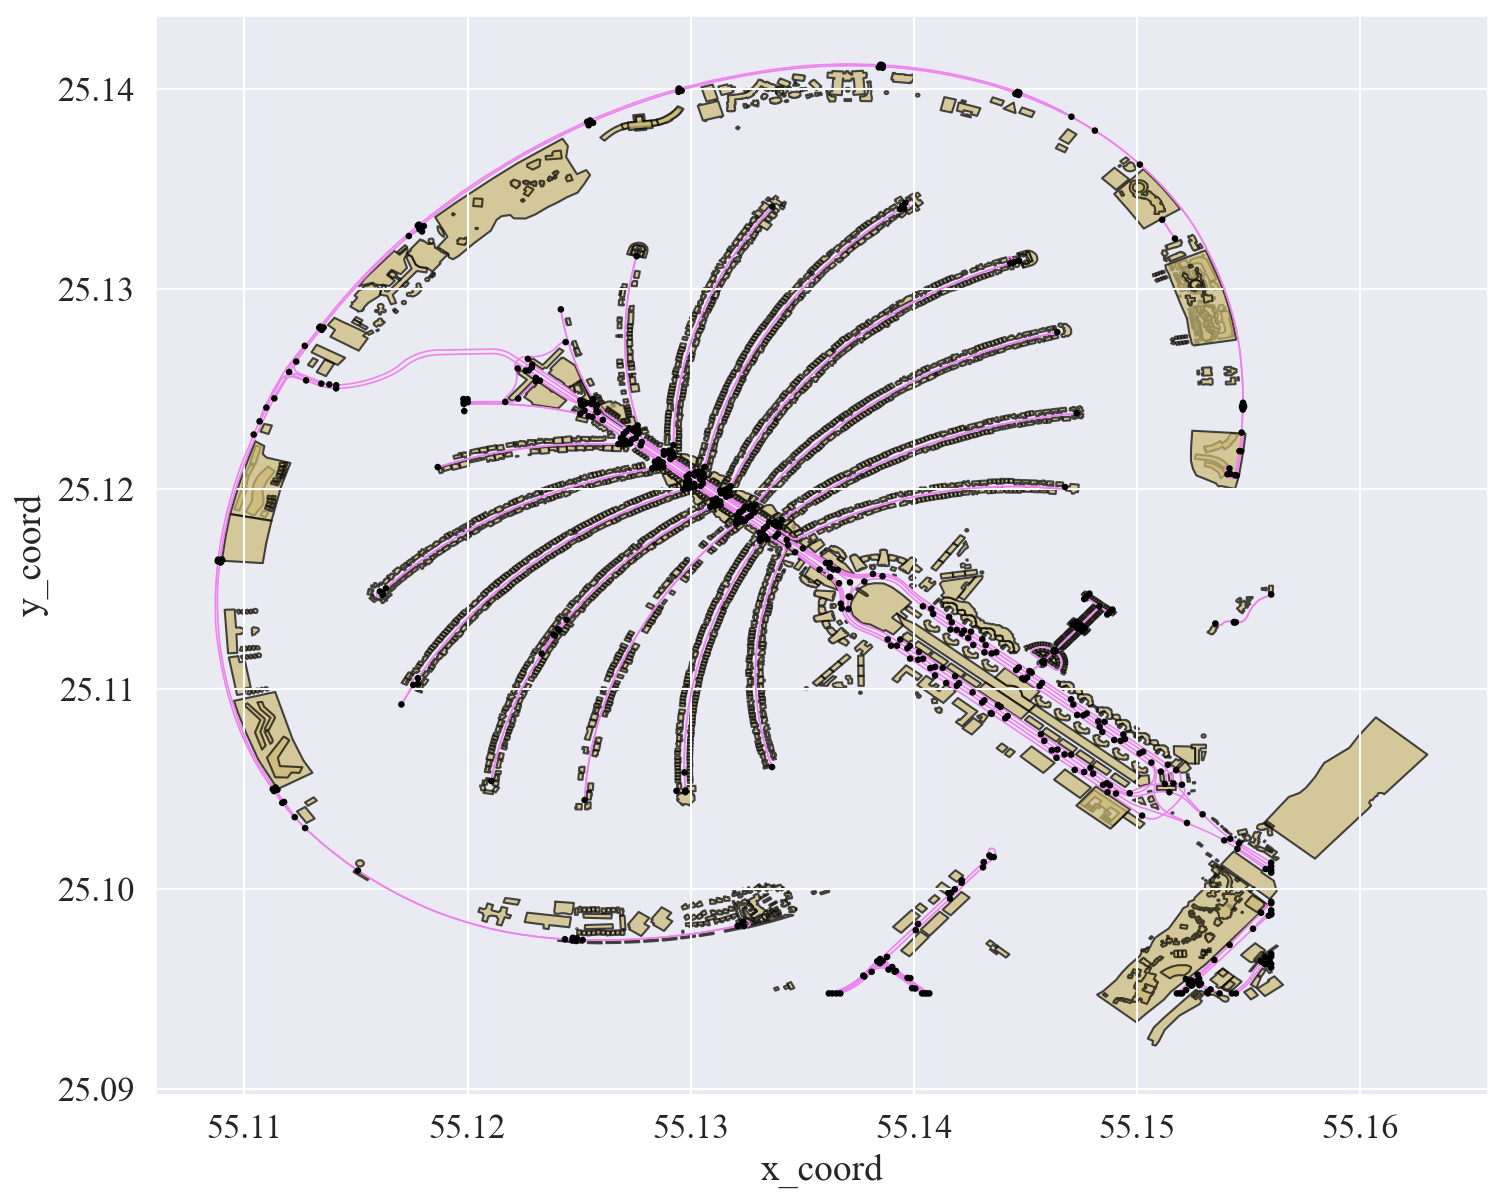

In [57]:
# Step 3: generate read data and generate visualization
# draw 'all' modes network and save to png file
cf = p4g.show_network_by_modes(mnet=mnet)
# show the figure on the current window
cf.show()

Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_mode_1.png


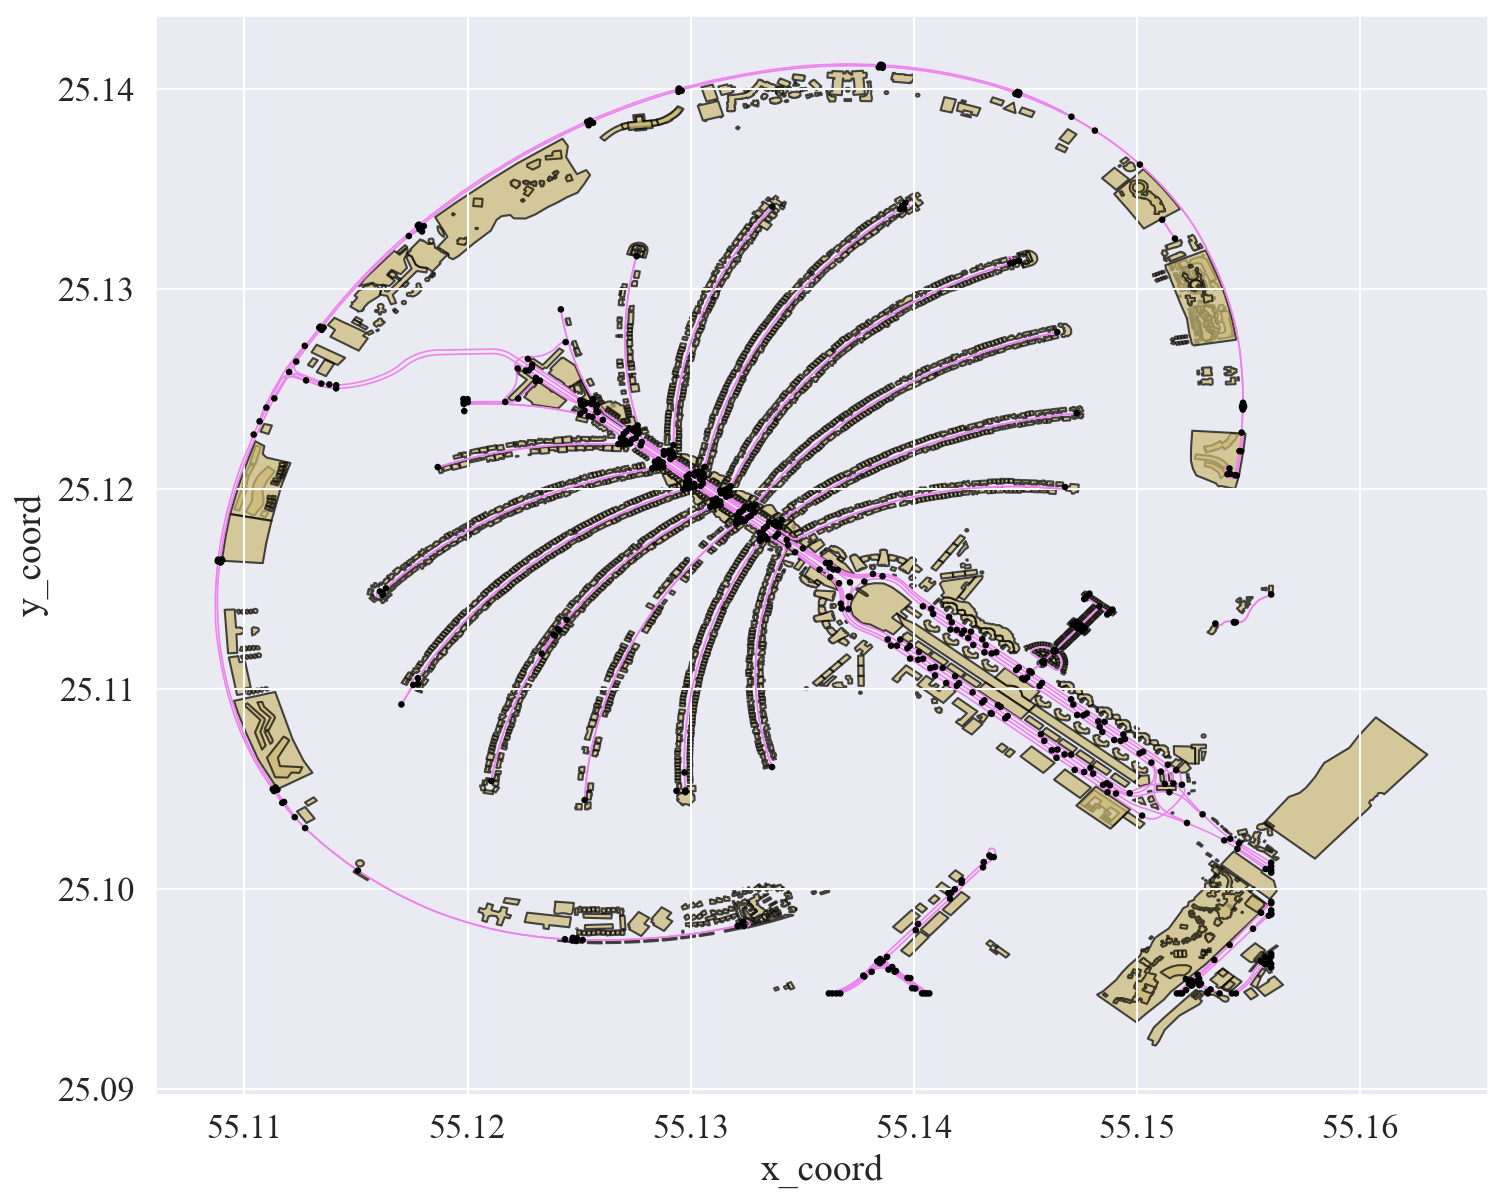

In [58]:
# show 'auto' mode network 
# can not show bike modes since the selected region have no bike links
cf = p4g.show_network_by_modes(mnet=mnet, modes=['auto'])
cf.show()  # show the figure on the current window


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_node_type.png


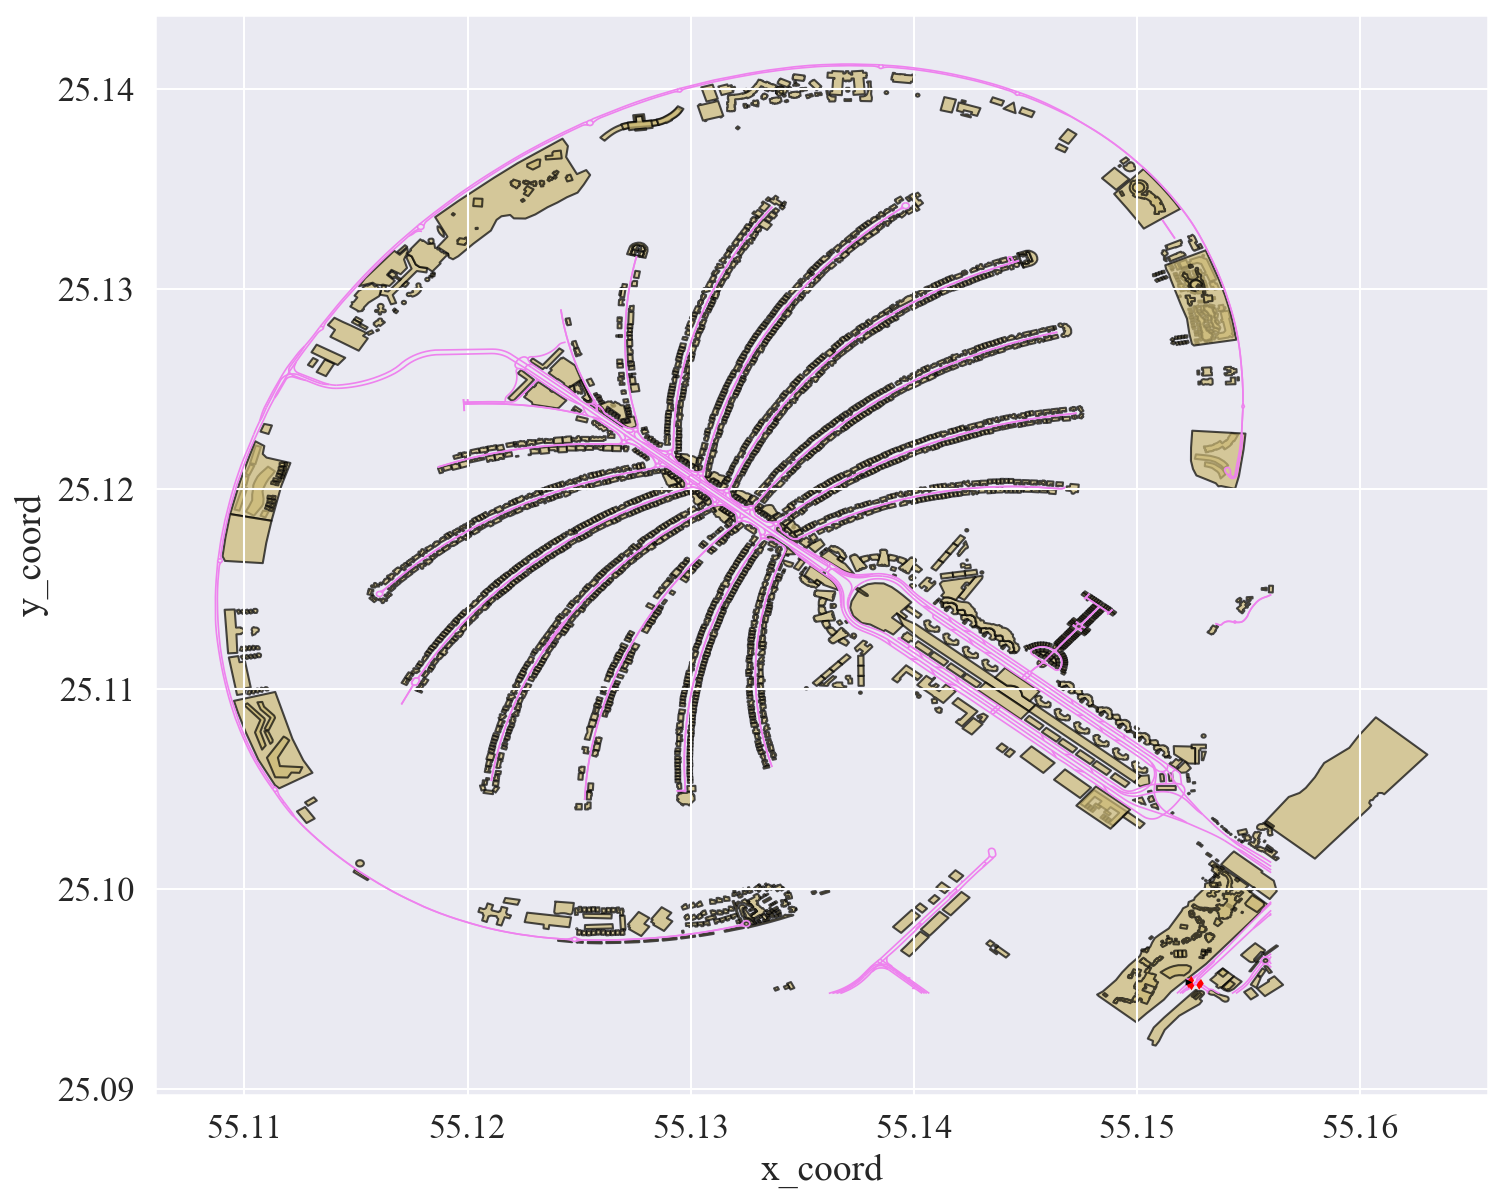

In [59]:
cf = p4g.show_network_by_node_types(
    mnet=mnet, osm_highway=['traffic_signals', 'crossing'])
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_link_type.png


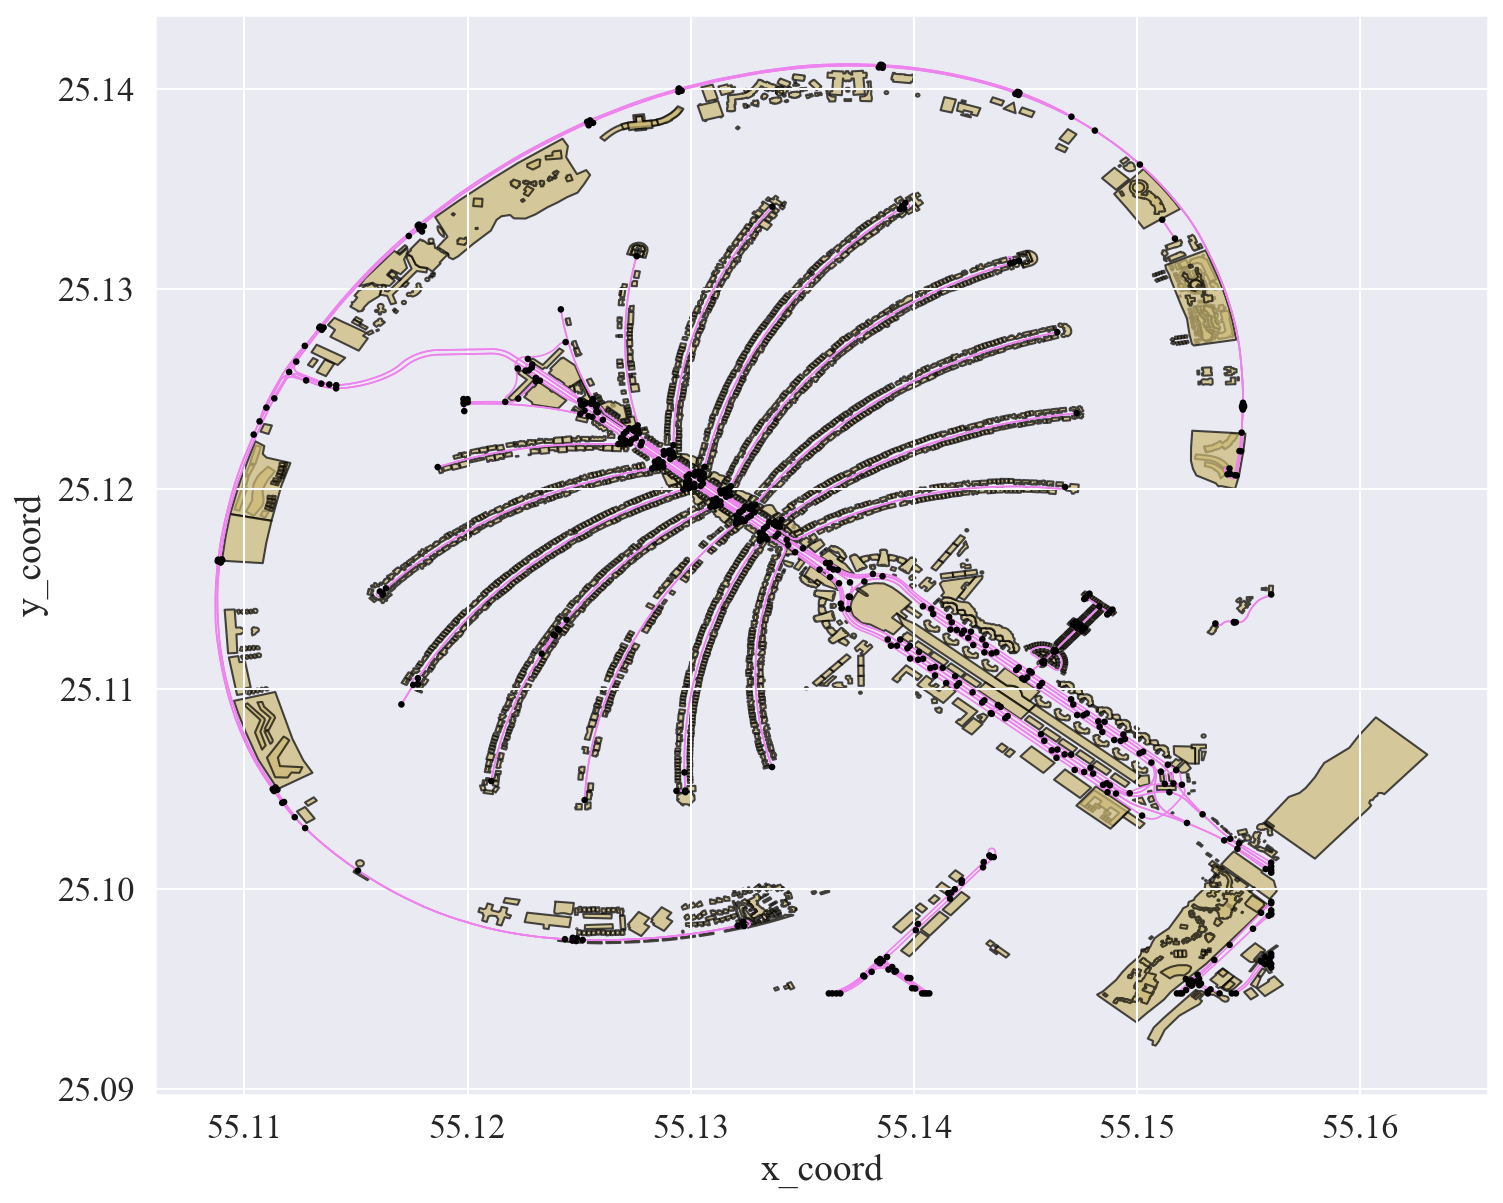

In [60]:
# show network by given link types
cf = p4g.show_network_by_link_types(
    mnet=mnet, link_types=['secondary', 'footway'])
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_link_length.png


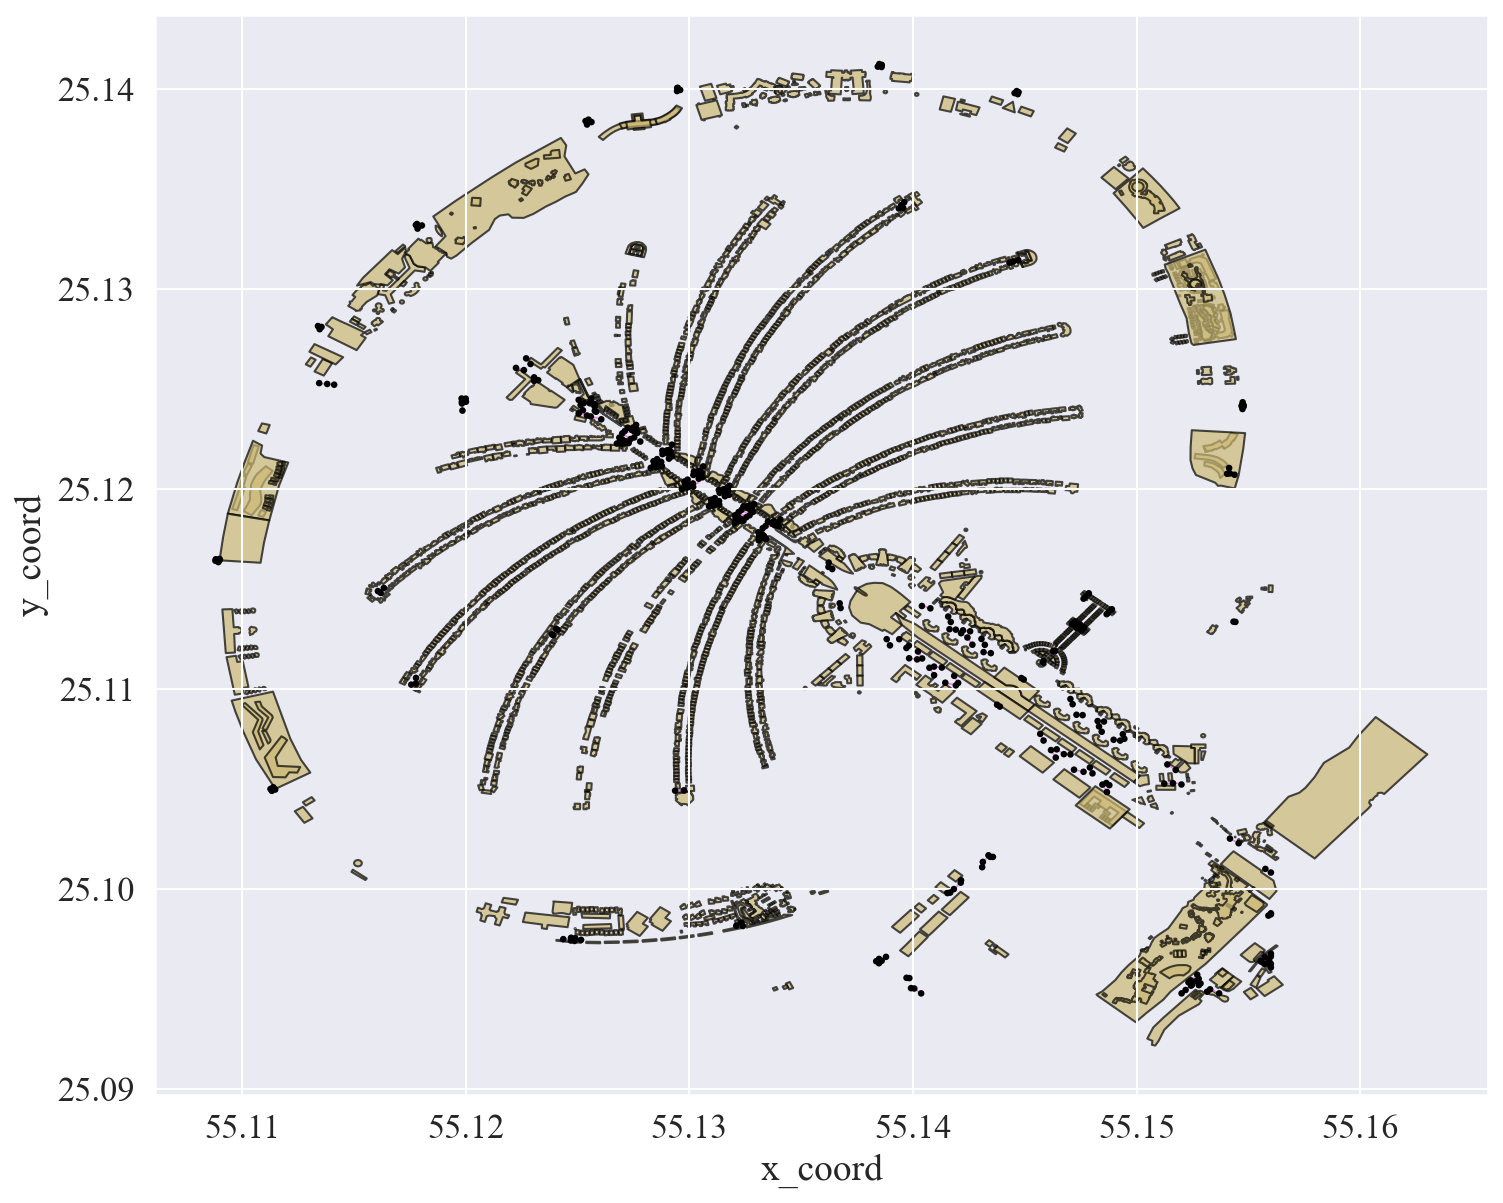

In [61]:
# show network by given link length range
cf = p4g.show_network_by_link_length(mnet=mnet, min_length=10, max_length=50)
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_link_lane.png


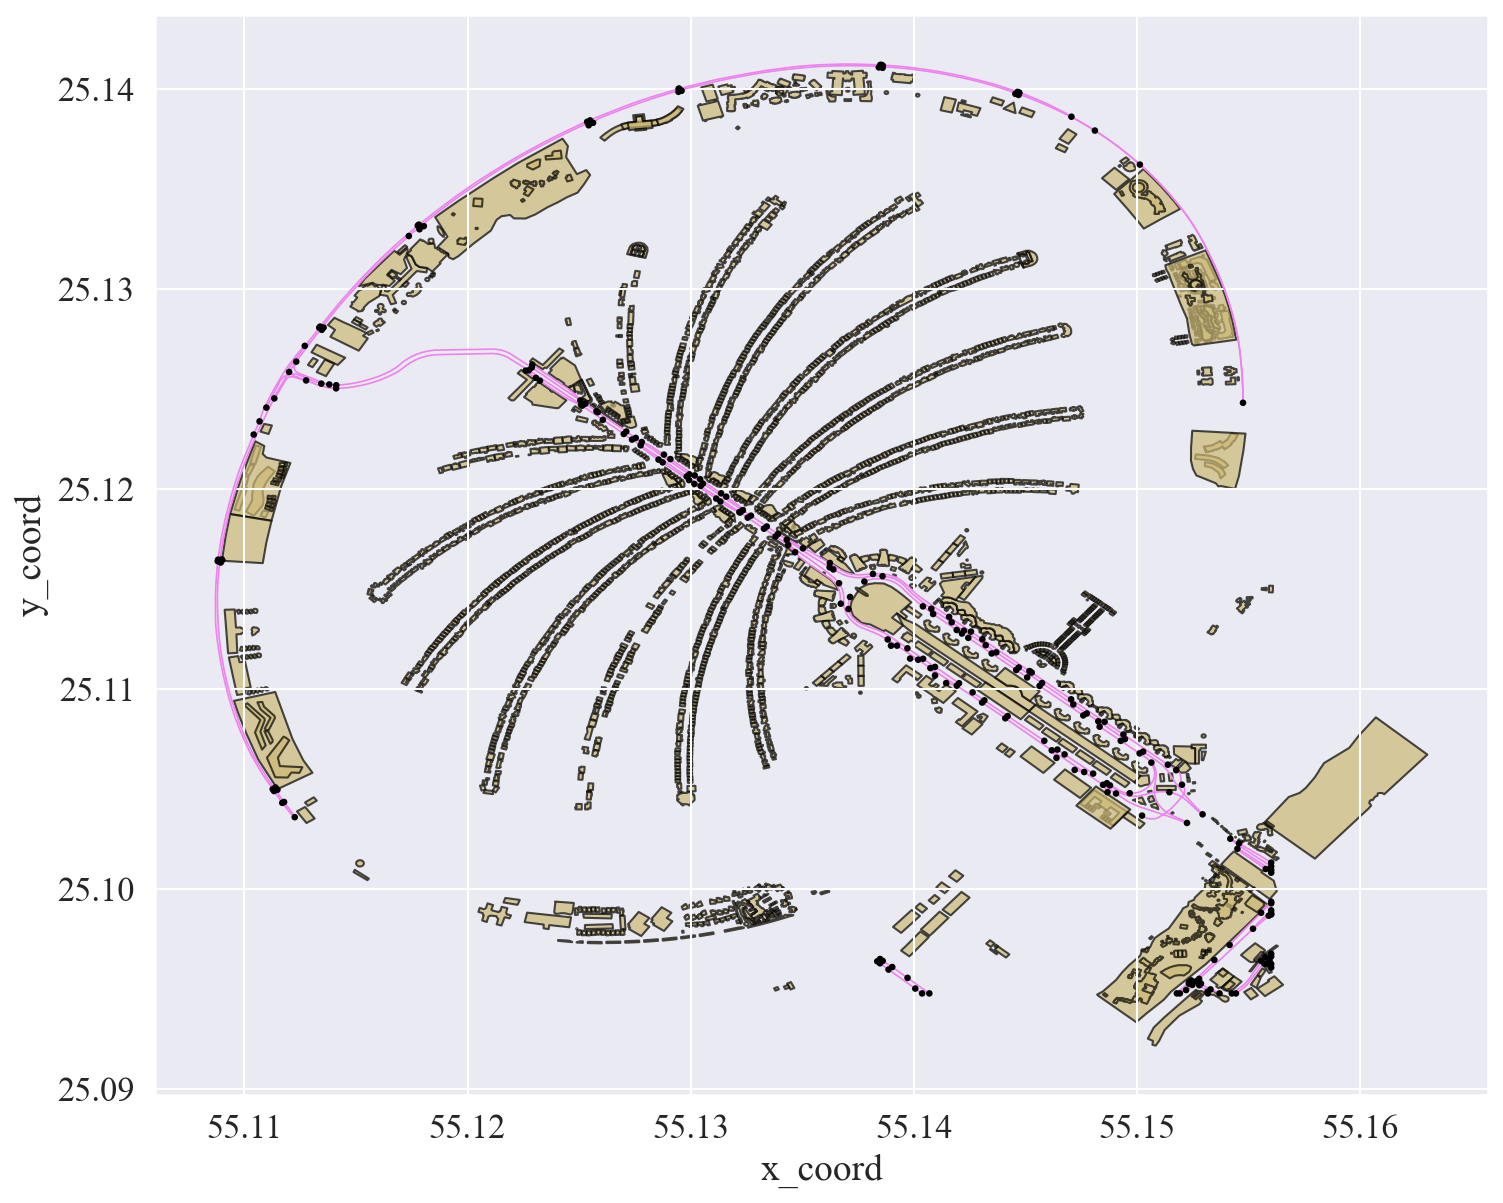

In [62]:
# show network by given link lane range
cf = p4g.show_network_by_link_lanes(mnet=mnet, min_lanes=1, max_lanes=3)
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_link_free_speed.png


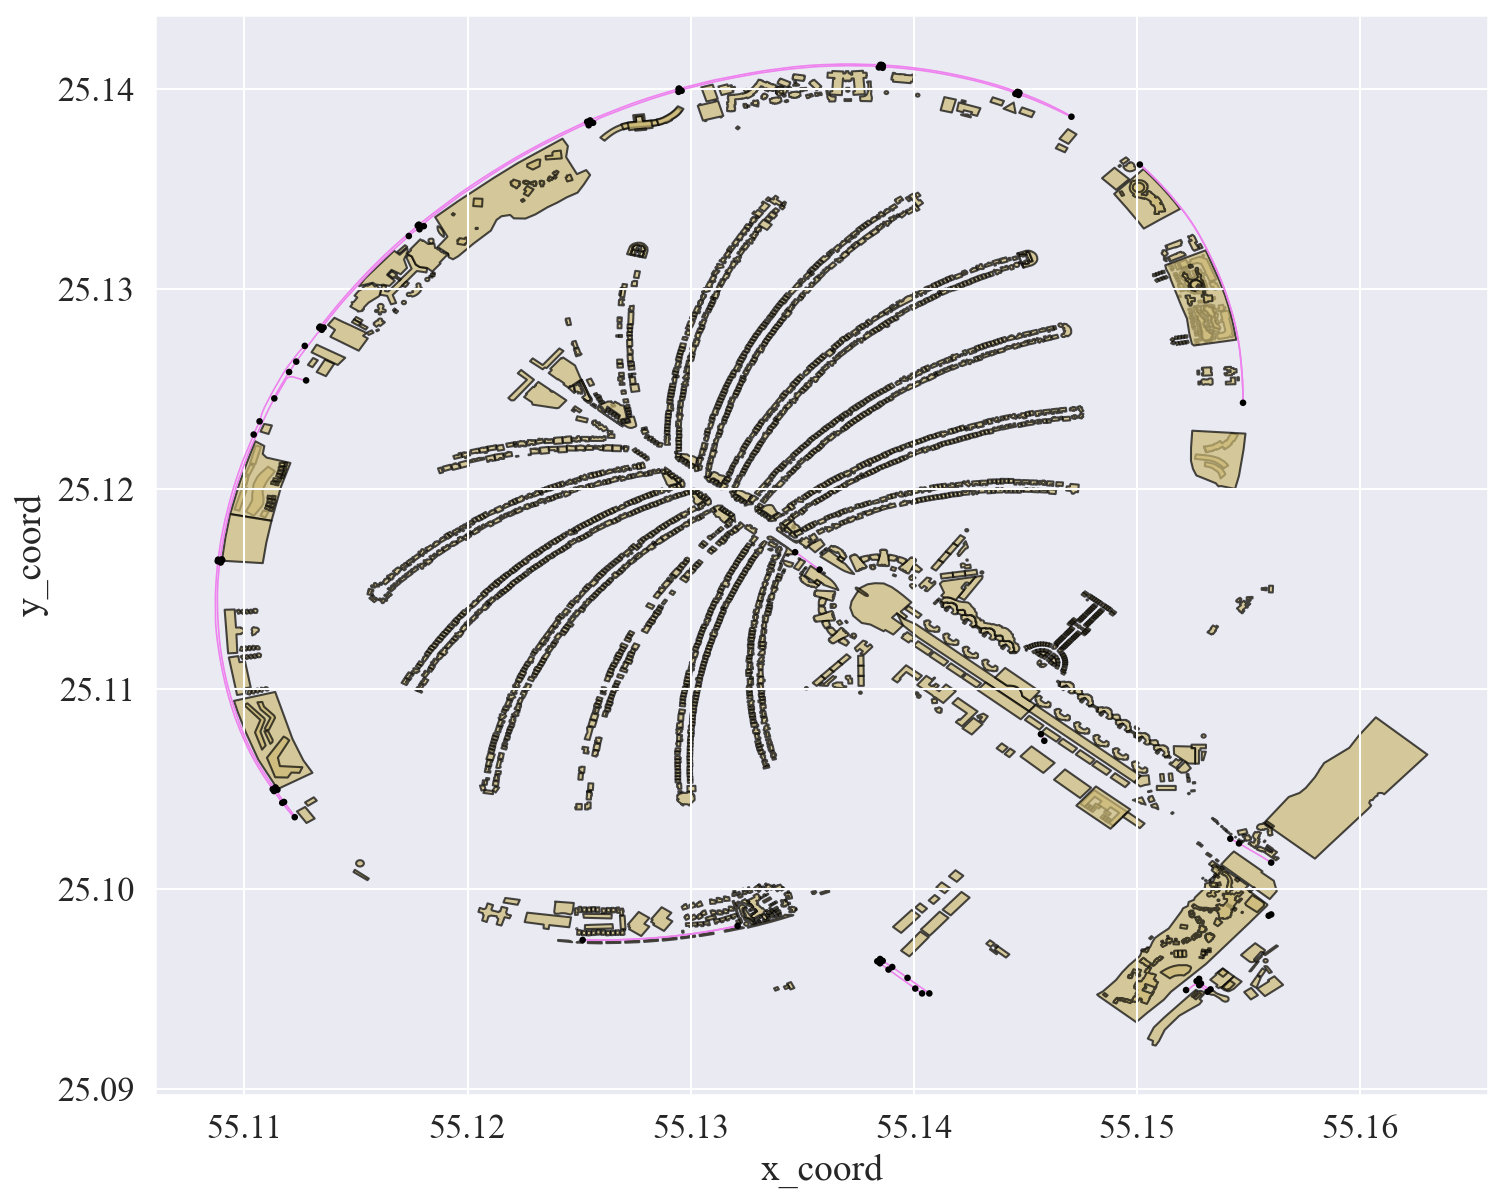

In [63]:
# show network by given link free speed range
cf = p4g.show_network_by_link_free_speed(
    mnet=mnet, min_free_speed=10, max_free_speed=40)
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_poi_type.png


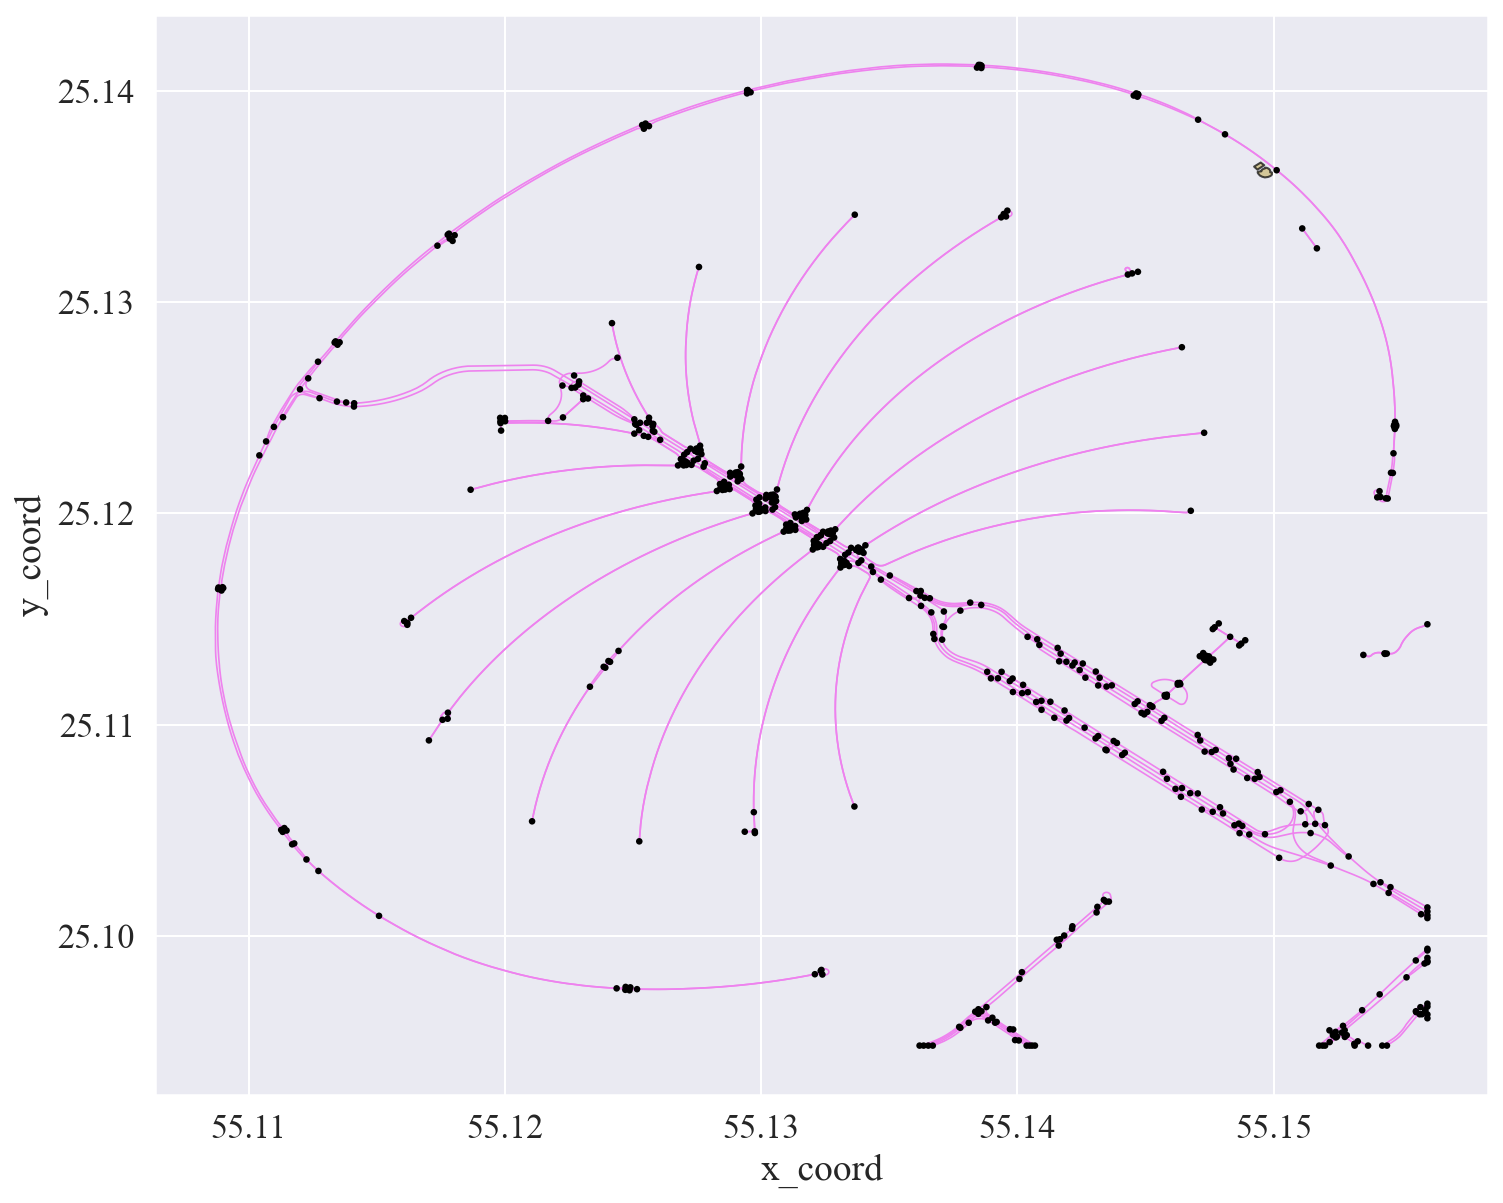

In [64]:
cf = p4g.show_network_by_poi_types(
    mnet=mnet, poi_type=['public', 'industrial'])
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_demand_matrix_heatmap.png


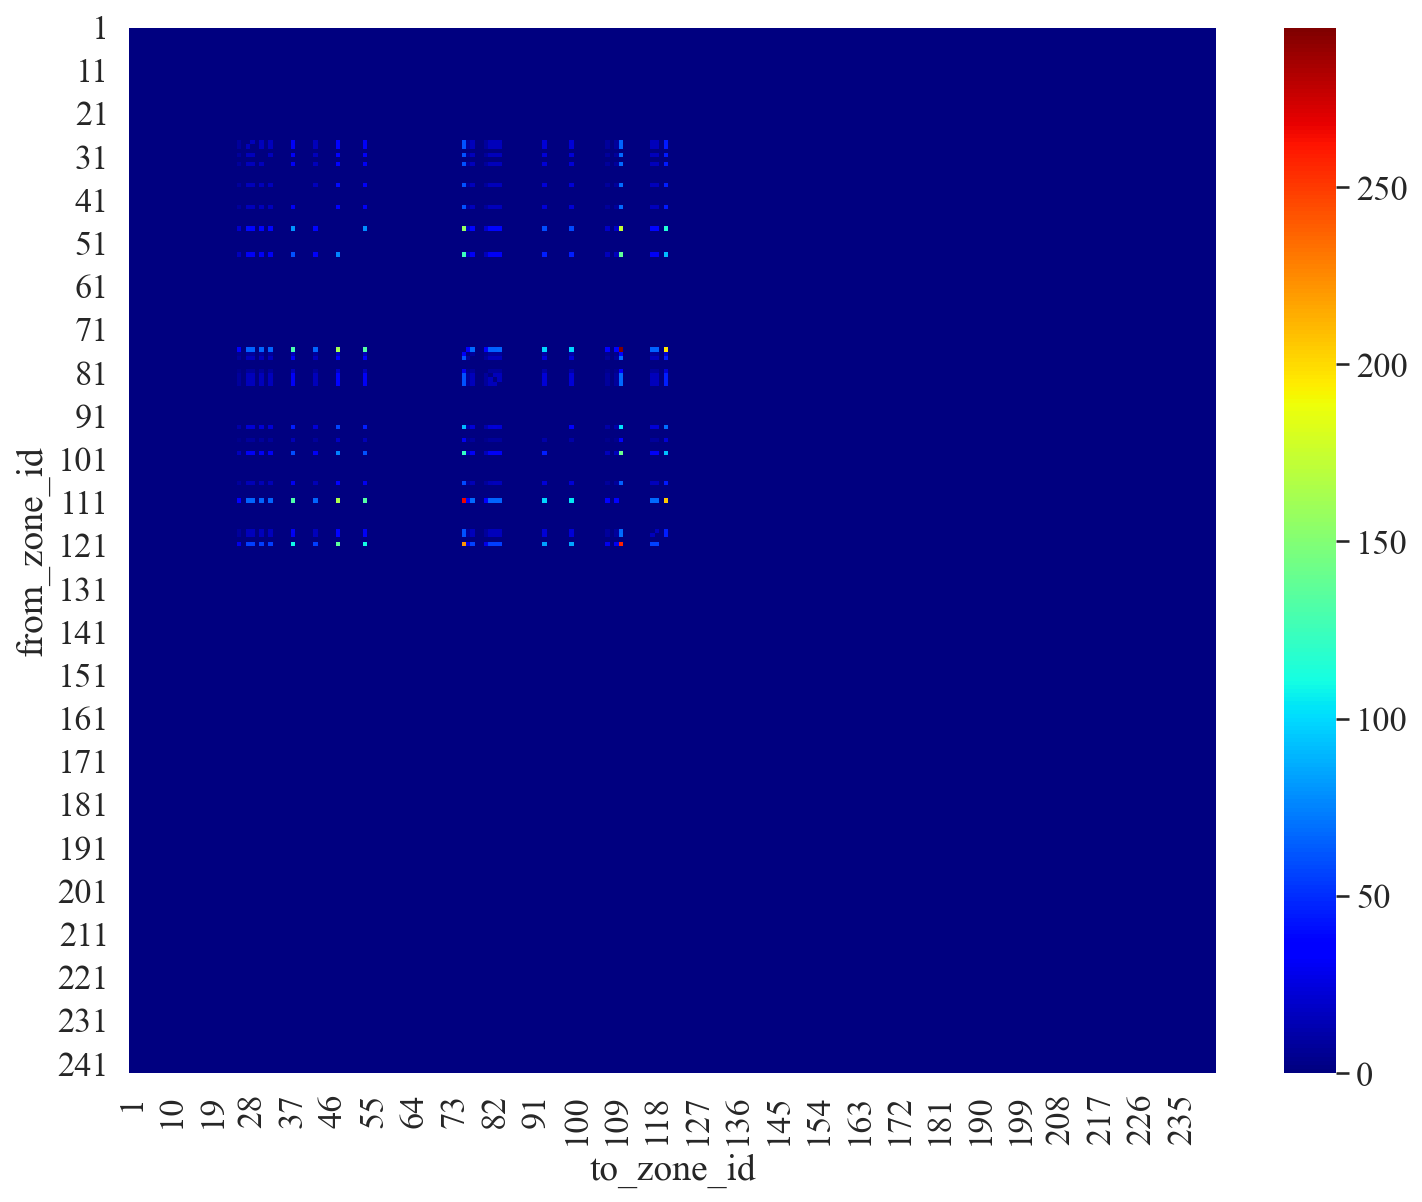

In [65]:
cf = p4g.show_network_demand_matrix_heatmap(mnet)
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_demand_od.png


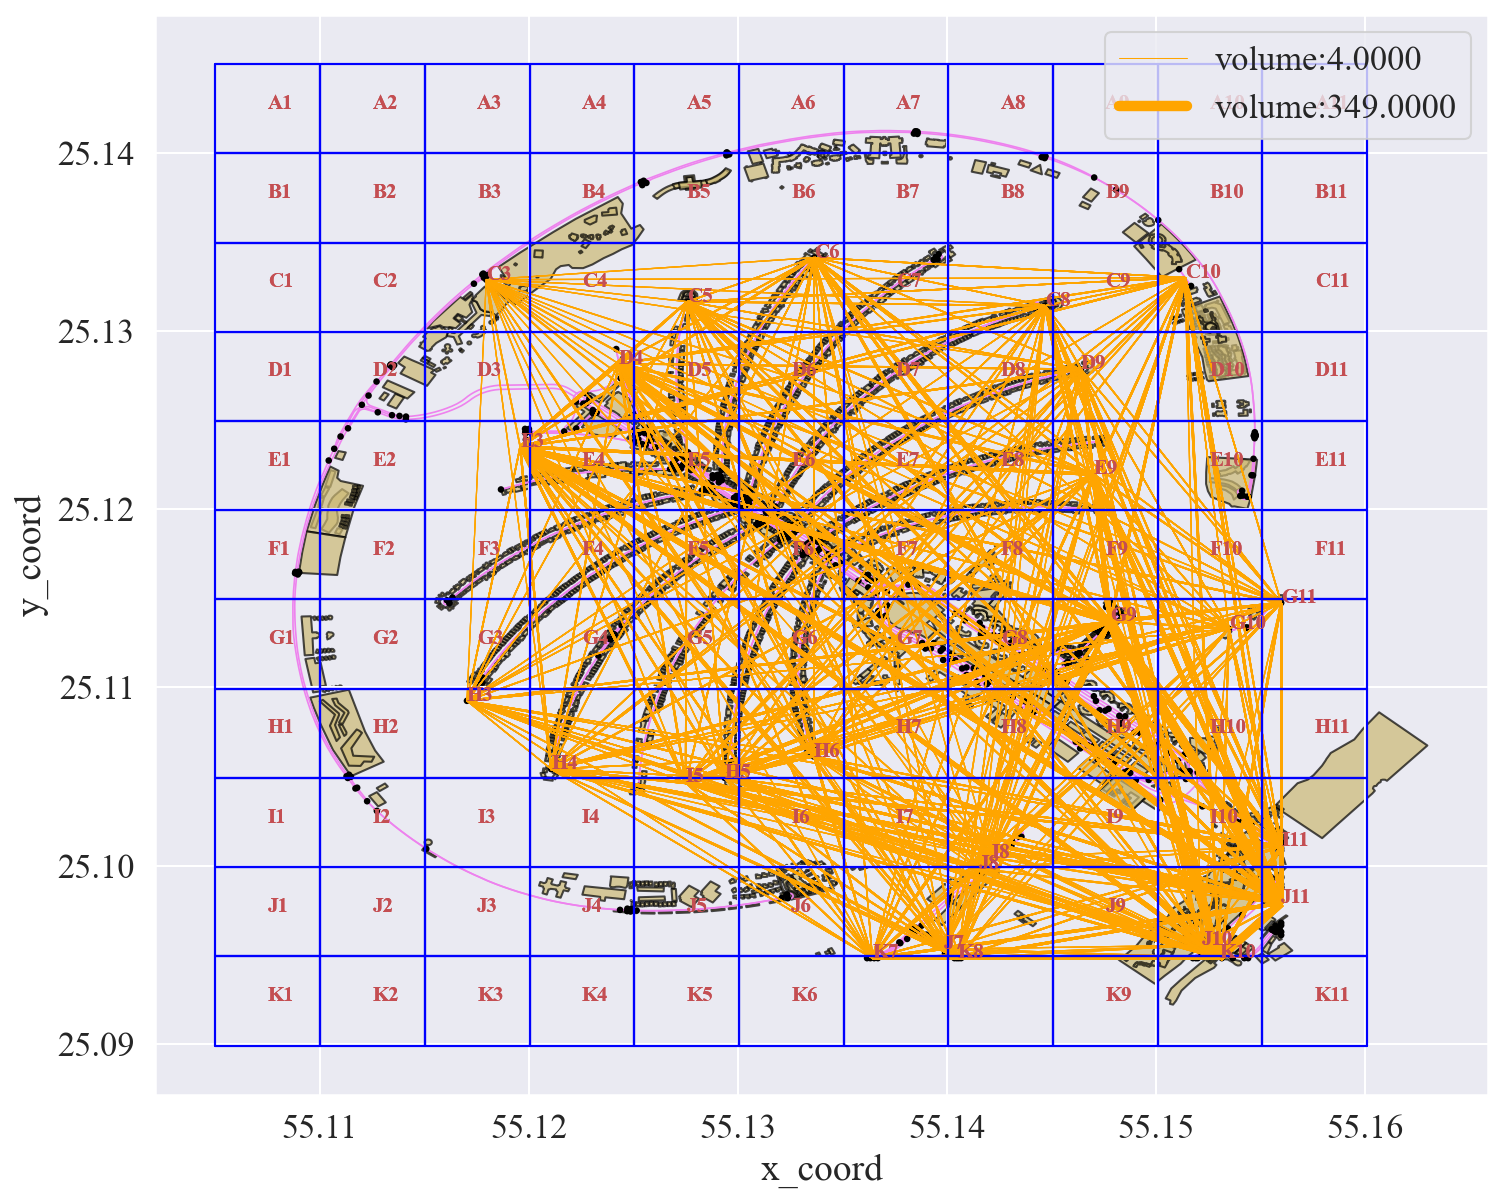

In [66]:
cf = p4g.show_network_by_demand_OD(mnet=mnet, load_network=True)
cf.show()


Successfully save figure to /Users/mustafagadah/Dropbox (ASU)/grid2demandlite_dubai/p4g_fig_results/network_by_mode_1_1.png


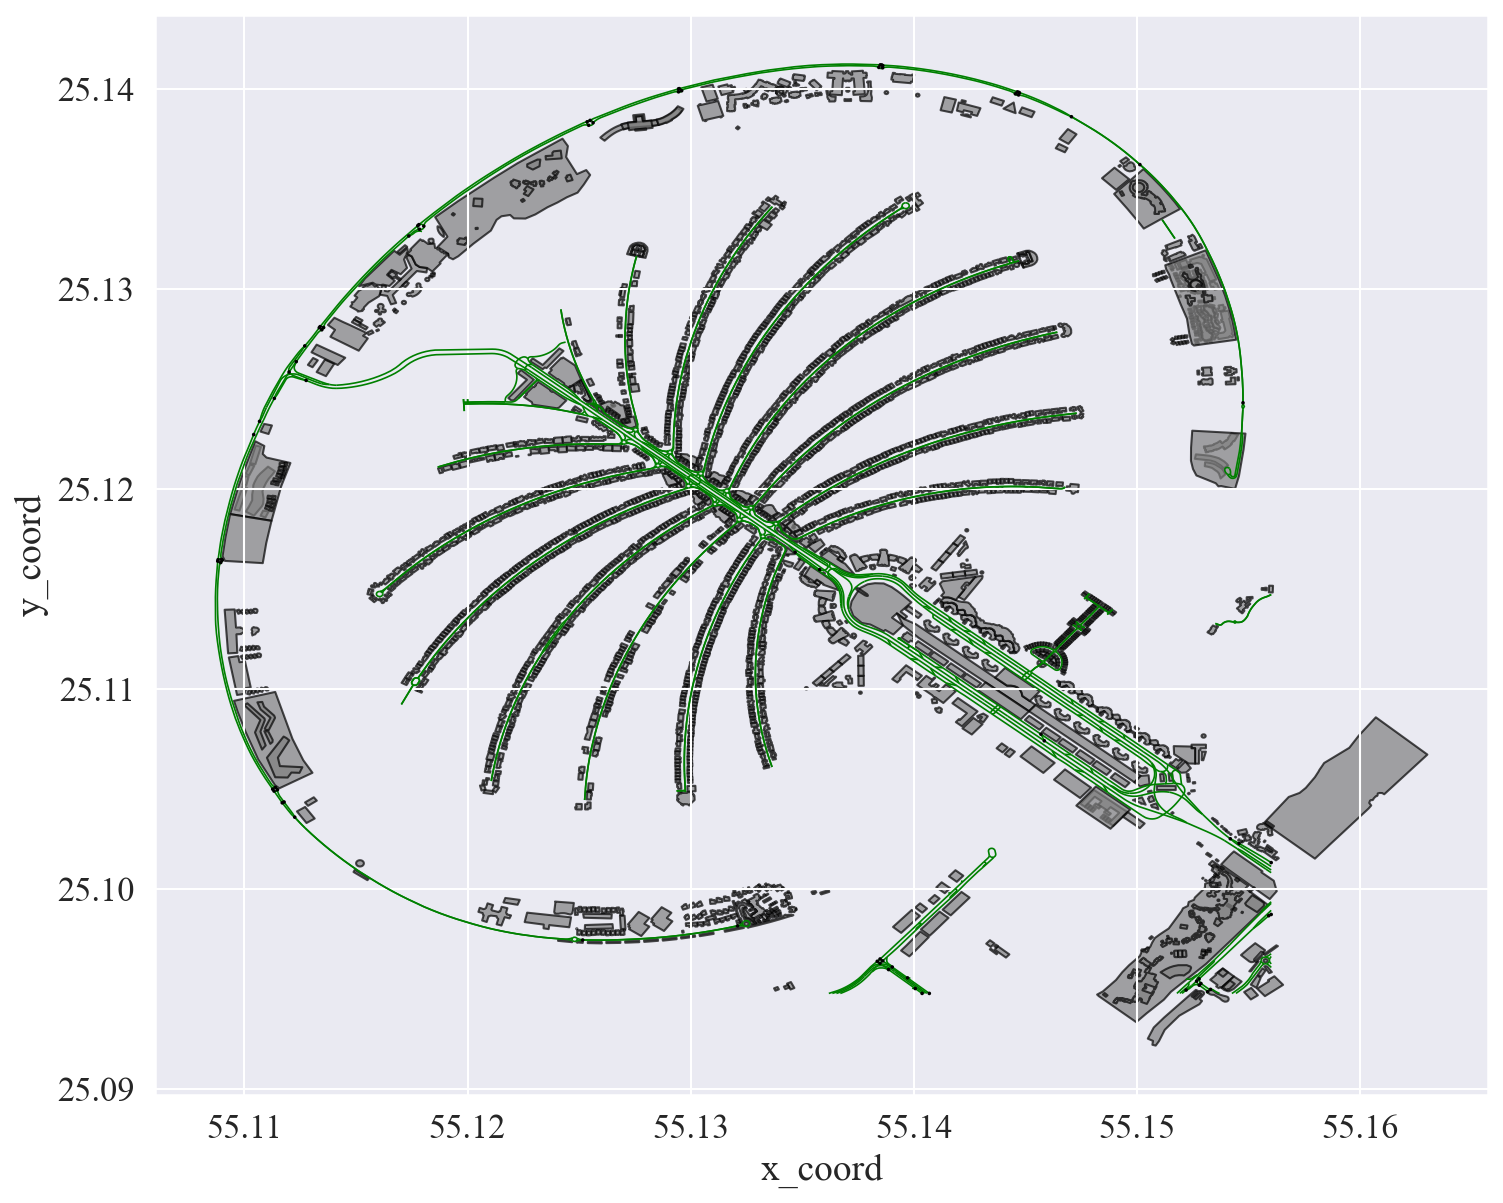

In [67]:
mnet.style.node_style.size = 3
mnet.style.link_style.linecolor = 'green'
mnet.style.poi_style.facecolor = 'gray'
cf = p4g.show_network_by_modes(mnet=mnet)
cf.show()


## 5. Traffic assignment and simulation 

Path4GMNS is used to run the traffic assignment. Path4GMNS is an open-source, lightweight, and fast Python path engine for networks encoded in GMNS. Besides finding the static and time-dependent shortest path for simple analyses, its main functionality is to provide an efficient and flexible framework for column(path)-based modeling/application frameworks in transportations (e.g., activity-based demand modeling).

### 5.1. Instale path4gmns package

In [ ]:
# !pip install path4gmns==0.8.8a2
# this will install latest version of the package
!pip install path4gmns
"""import package"""
import path4gmns as pg 
import pandas as pd
from time import time

### 5.2. Import network data
Mode 1: finding single-pair shortest path

In [ ]:
import path4gmns as pg

load_demand = False
network = pg.read_network(load_demand)

print('\nshortest path (node id) from node 1 to node 2 is '
      + network.find_shortest_path(1, 2))
print('\nshortest path (link id) from node 1 to node 2 is '
      + network.find_shortest_path(1, 2, 'link'))


Mode 2: shortest paths for all agents (to be tested as a change of function names in the recent release).

In [ ]:
import path4gmns as pg

network = pg.read_network()
network.find_path_for_agents()

agent_id = 300
print('\norigin node id of agent is '
      + str(network.get_agent_orig_node_id(agent_id)))

print('destination node id of agent is '
      + str(network.get_agent_dest_node_id(agent_id)))

print('shortest path (node id) of agent is '
      + str(network.get_agent_node_path(agent_id)))

print('shortest path (link id) of agent is '
      + str(network.get_agent_link_path(agent_id)))

agent_id = 1000
print('\norigin node id of agent is '
      + str(network.get_agent_orig_node_id(agent_id)))

print('destination node id of agent is '
      + str(network.get_agent_dest_node_id(agent_id)))

print('shortest path (node id) of agent is '
      + str(network.get_agent_node_path(agent_id)))

print('shortest path (link id) of agent is '
      + str(network.get_agent_link_path(agent_id)))


Mode 3: column generation


In [ ]:
import path4gmns as pg

network = pg.read_network()

# path-based UE
mode = 1
assignment_num = 5
column_update_num = 5

pg.perform_network_assignment(mode, assignment_num, column_update_num, network)

pg.output_columns(network)
pg.output_link_performance(network)

print('\npath finding results can be found in agent.csv')


Mode 4 : DTALite
